In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection
from transformers import BertTokenizer, BertModel
import torch



In [3]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load dataset
df1 = pd.read_excel(r'/Users/andrewsimon/Desktop/PSE Dataset.xlsx', sheet_name='SamePerson Report')
df2 = pd.read_excel(r'/Users/andrewsimon/Desktop/PSE Dataset.xlsx', sheet_name='Multiple People Report')
df3 = pd.read_excel(r'/Users/andrewsimon/Desktop/PSE Dataset.xlsx', sheet_name='Multiple People Less Details')

train_1, test_1 = sklearn.model_selection.train_test_split(df1, test_size=0.2, random_state=206)
train_2, test_2 = sklearn.model_selection.train_test_split(df2, test_size=0.2, random_state=206)
train_3, test_3 = sklearn.model_selection.train_test_split(df3, test_size=0.2, random_state=206)

train_1_text = train_1['Report'].values.reshape(-1,1)
test_1_text = test_1['Report'].values.reshape(-1,1)

train_1_label = train_1['Level'].values.reshape(-1,1)
test_1_label = test_1['Level'].values.reshape(-1,1)

train_2_text = train_2['Report'].values.reshape(-1,1)
test_2_text = test_2['Report'].values.reshape(-1,1)

train_2_label = train_2['Level'].values.reshape(-1,1)
test_2_label = test_2['Level'].values.reshape(-1,1)

train_3_text = train_3['Report'].values.reshape(-1,1)
test_3_text = test_3['Report'].values.reshape(-1,1)

train_3_label = train_3['Level'].values.reshape(-1,1)
test_3_label = test_3['Level'].values.reshape(-1,1)



In [4]:
# Define functions for tokenizing the text data using BERT tokenizer
def tokenize_text(text):
    input_ids = []
    attention_masks = []

    for sentence in text:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=512,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks




In [5]:
train_1_text_list = train_1_text.tolist()
train_1_text_str = [item for sublist in train_1_text_list for item in sublist]

test_1_text_list = test_1_text.tolist()
test_1_text_str = [item for sublist in test_1_text_list for item in sublist]

train_1_label_list = train_1_label.tolist()
train_1_label_str = [item for sublist in train_1_label_list for item in sublist]

test_1_label_list = test_1_label.tolist()
test_1_label_str = [item for sublist in test_1_label_list for item in sublist]



In [6]:
# Tokenize the train dataset
train_input_ids, train_attention_masks = tokenize_text(train_1_text_str)
train_labels = torch.tensor(train_1_label_str)

# Tokenize the test dataset
test_input_ids, test_attention_masks = tokenize_text(test_1_text_str)
test_labels = torch.tensor(test_1_label_str)

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to the device
train_input_ids = train_input_ids.to(device)
train_attention_masks = train_attention_masks.to(device)
train_labels = train_labels.to(device)

test_input_ids = test_input_ids.to(device)
test_attention_masks = test_attention_masks.to(device)
test_labels = test_labels.to(device)

# Forward pass through BERT model
with torch.no_grad():
    train_outputs = model(train_input_ids, attention_mask=train_attention_masks)
    test_outputs = model(test_input_ids, attention_mask=test_attention_masks)

train_features = train_outputs.pooler_output
test_features = test_outputs.pooler_output

# Convert features to numpy arrays
train_x = train_features.cpu().numpy()
test_x = test_features.cpu().numpy()
train_y = train_labels.cpu().numpy()
test_y = test_labels.cpu().numpy()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when

In [7]:
# Train a Random Forest model
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
rf_model.fit(train_x, train_y)

RandomForestClassifier(n_estimators=200)

In [8]:
# Accuracy report
print("Model accuracy:", rf_model.score(test_x, test_y))

Model accuracy: 0.55


In [9]:
# Prediction and classification report
predict_y = rf_model.predict(test_x)
print(sklearn.metrics.classification_report(test_y, predict_y, digits=4))

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000         2
           2     0.0000    0.0000    0.0000         0
           3     1.0000    0.3333    0.5000         6
           4     0.7500    0.5000    0.6000         6
           5     1.0000    0.8333    0.9091         6

    accuracy                         0.5500        20
   macro avg     0.6500    0.4333    0.5018        20
weighted avg     0.8750    0.5500    0.6527        20



/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


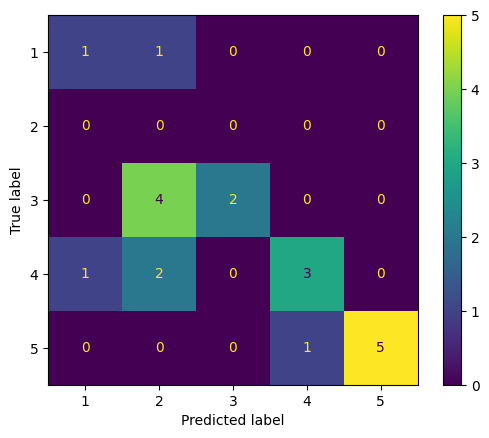

In [10]:
# Plot a confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(rf_model, test_x, test_y)